# SILLEO-SCNS Routing Protocol Analysis

## Data Overview

This notebook analyzes the performance of different routing protocols (AODV, OSPF, GPSR) in the LEO satellite constellation simulation.

### Dataset Information
- **Source**: Parquet files generated from SILLEO-SCNS simulation runs
- **Location**: `data/` folder
- **File Format**: New naming convention includes protocol, network design, node count, and source-destination pairs
- **Time Period**: Statistics collected during active simulation runs

### Key Metrics Collected
1. **Execution Time** (microseconds) - Time taken by each routing algorithm
2. **Number of Hops** - Path length in terms of network hops
3. **Total Distance** (meters) - Physical distance of the route
4. **Route Success** - Whether a valid path was found
5. **Source/Destination** - Actual city names instead of numeric IDs
6. **Network Design** - SPARSE, +GRID, or IDEAL linking methods
7. **Protocol** - AODV, OSPF, or GPSR routing algorithms

### Research Questions
This analysis addresses 7 key questions:
1. What is the minimum number of nodes to guarantee less than 1% error rate?
2. What is the algorithm that generates less route changes?
3. What algorithm has the smallest error rate given the same network design and number of nodes?
4. How algorithms degrades delivery with increasing number of nodes?
5. Which algorithms are more robust to each network design?
6. Is the number of links per node directly related to better routing?
7. What is the best routing algorithm to choose for LEO Satellites constellation?

### Expected Outcomes
- Performance comparison across routing protocols
- CDF analysis of execution times
- Network design impact assessment
- Scalability analysis with node count
- Recommendations for LEO satellite constellations

In [107]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [108]:
# Find all Parquet files in the data directory
data_dir = Path('data')
parquet_files = list(data_dir.glob('*.parquet'))

print(f"Found {len(parquet_files)} Parquet files:")
for file in parquet_files:
    print(f"  - {file.name}")

# Load all data into a single DataFrame
dfs = []
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        
        # Extract information from filename
        filename_parts = file.stem.split('-')
        if len(filename_parts) >= 4:
            df['protocol'] = filename_parts[0]
            df['network_design'] = filename_parts[1]
            df['num_nodes'] = int(filename_parts[2].replace('nodes', ''))
            df['src_dst_pair'] = filename_parts[3]
            df['timestamp_file'] = filename_parts[4] if len(filename_parts) > 4 else 'unknown'
        
        df['source_file'] = file.name
        dfs.append(df)
        print(f"  ✓ Loaded {len(df)} records from {file.name}")
    except Exception as e:
        print(f"  ✗ Error loading {file.name}: {e}")

if dfs:
    data = pd.concat(dfs, ignore_index=True)
    print(f"\n✅ Total records loaded: {len(data):,}")
    print(f"📊 Data shape: {data.shape}")
else:
    print("❌ No Parquet files found. Please run the simulation first.")
    data = pd.DataFrame()

Found 39 Parquet files:
  - AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouver-1751246296.parquet
  - OSPF-plusGRID-1152nodes-Belo_Horizonte-Vancouver-1750625508.parquet
  - AODV-SPARSE-704nodes-Belo_Horizonte-Zurich-1751245367.parquet
  - AODV-plusGRID-912nodes-Belo_Horizonte-Zurich-1751245731.parquet
  - AODV-plusGRID-1152nodes-Belo_Horizonte-Cape_Town-1751246445.parquet
  - GPSR-plusGRID-1152nodes-Belo_Horizonte-Zurich-1750624863.parquet
  - OSPF-plusGRID-704nodes-Belo_Horizonte-Zurich-1750623347.parquet
  - AODV-SPARSE-912nodes-Belo_Horizonte-Zurich-1751245597.parquet
  - AODV-SPARSE-528nodes-Belo_Horizonte-Zurich-1751245055.parquet
  - OSPF-plusGRID-1152nodes-Belo_Horizonte-Zurich-1750624739.parquet
  - OSPF-SPARSE-528nodes-Belo_Horizonte-Zurich-1750622530.parquet
  - AODV-SPARSE-1152nodes-Belo_Horizonte-Zurich-1751245941.parquet
  - GPSR-SPARSE-384nodes-Belo_Horizonte-Zurich-1750621912.parquet
  - OSPF-SPARSE-912nodes-Belo_Horizonte-Zurich-1750623663.parquet
  - GPSR-plusGRID-912no

In [109]:
# Display basic information about the dataset
if not data.empty:
    print("📋 DATASET OVERVIEW")
    print("=" * 60)
    
    print("\n📈 Dataset Info:")
    print("-" * 30)
    print(data.info())
    
    print("\n🔢 Summary Statistics:")
    print("-" * 30)
    display(data.describe())
    
    print("\n📁 First few records:")
    print("-" * 30)
    display(data.head())
    
    print("\n🎯 Unique values in key columns:")
    print("-" * 30)
    print(f"Protocols: {data['protocol'].unique()}")
    print(f"Network Designs: {data['network_design'].unique()}")
    print(f"Number of Nodes: {sorted(data['num_nodes'].unique())}")
    print(f"Source-Destination Pairs: {len(data['src_dst_pair'].unique())} unique pairs")
    
    # Show sample of source-destination pairs
    print(f"\n📍 Sample Source-Destination Pairs:")
    print("-" * 30)
    for pair in data['src_dst_pair'].unique()[:10]:
        print(f"  - {pair}")
    if len(data['src_dst_pair'].unique()) > 10:
        print(f"  ... and {len(data['src_dst_pair'].unique()) - 10} more pairs")
else:
    print("❌ No data available for analysis.")

📋 DATASET OVERVIEW

📈 Dataset Info:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116877 entries, 0 to 116876
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   protocol_name     116877 non-null  object 
 1   number_of_nodes   116877 non-null  int64  
 2   orbit_height      116877 non-null  float64
 3   network_design    116877 non-null  object 
 4   timestamp         116877 non-null  float64
 5   source_node       116877 non-null  object 
 6   destination_node  116877 non-null  object 
 7   time_taken_us     116877 non-null  float64
 8   num_hops          116877 non-null  int64  
 9   total_distance    116877 non-null  int64  
 10  route_path        116877 non-null  object 
 11  protocol          116877 non-null  object 
 12  num_nodes         116877 non-null  int64  
 13  src_dst_pair      116877 non-null  object 
 14  timestamp_file    116877 non-null  object 
 15  s

,number_of_nodes,orbit_height,timestamp,time_taken_us,num_hops,total_distance,num_nodes
count,116877.000000,116877.0,116877.000000,116877.000000,116877.000000,1.168770e+05,116877.000000
mean,831.996304,500000.0,115313.907013,177.924082,5.425661,7.560069e+06,831.996304
std,296.640378,0.0,119342.738773,1311.558536,7.993441,9.657016e+06,296.640378
min,384.000000,500000.0,30.000000,-1.000000,-1.000000,-1.000000e+00,384.000000
25%,528.000000,500000.0,22530.000000,-1.000000,-1.000000,-1.000000e+00,528.000000
50%,912.000000,500000.0,71060.000000,30.750000,7.000000,8.259962e+06,912.000000
75%,1152.000000,500000.0,159530.000000,209.459000,9.000000,1.192929e+07,1152.000000
max,1152.000000,500000.0,449980.000000,123463.292000,93.000000,1.253559e+08,1152.000000



📁 First few records:
------------------------------


,protocol_name,number_of_nodes,orbit_height,network_design,timestamp,source_node,destination_node,time_taken_us,num_hops,total_distance,route_path,protocol,num_nodes,src_dst_pair,timestamp_file,source_file
0,AODV,1152,500000.0,plusGRID,40.0,Belo_Horizonte,Vancouver,-1.0,-1,-1,[],AODV,1152,Belo_Horizonte,Vancouver,AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouv...
1,AODV,1152,500000.0,plusGRID,50.0,Belo_Horizonte,Vancouver,-1.0,-1,-1,[],AODV,1152,Belo_Horizonte,Vancouver,AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouv...
2,AODV,1152,500000.0,plusGRID,60.0,Belo_Horizonte,Vancouver,-1.0,-1,-1,[],AODV,1152,Belo_Horizonte,Vancouver,AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouv...
3,AODV,1152,500000.0,plusGRID,70.0,Belo_Horizonte,Vancouver,-1.0,-1,-1,[],AODV,1152,Belo_Horizonte,Vancouver,AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouv...
4,AODV,1152,500000.0,plusGRID,80.0,Belo_Horizonte,Vancouver,-1.0,-1,-1,[],AODV,1152,Belo_Horizonte,Vancouver,AODV-plusGRID-1152nodes-Belo_Horizonte-Vancouv...



🎯 Unique values in key columns:
------------------------------
Protocols: ['AODV' 'OSPF' 'GPSR']
Network Designs: ['plusGRID' 'SPARSE']
Number of Nodes: [384, 528, 704, 912, 1152]
Source-Destination Pairs: 1 unique pairs

📍 Sample Source-Destination Pairs:
------------------------------
  - Belo_Horizonte


## 2. Data Cleaning and Processing

In [110]:
if not data.empty:
    print("🧹 DATA CLEANING AND PROCESSING")
    print("=" * 50)
    
    # Create route success flag
    data['route_success'] = data['num_hops'] != -1
    
    # Calculate additional metrics
    data['avg_distance_per_hop'] = np.where(
        data['num_hops'] > 0, 
        data['total_distance'] / data['num_hops'], 
        np.nan
    )
    
    # Convert timestamp to datetime for better analysis
    data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Create error rate metric
    data['error_rate'] = 1 - data['route_success'].astype(int)
    
    # Extract source and destination from src_dst_pair
    #data[['source_city', 'dest_city']] = data['src_dst_pair'].str.split('-', expand=True)
    split_src_dst = data['src_dst_pair'].str.split('-', n=1, expand=True)
    split_src_dst = split_src_dst.reindex(columns=[0, 1])
    data['source_city'] = split_src_dst[0]
    data['dest_city'] = split_src_dst[1]
    
    # Clean up network design names for better readability
    data['network_design_clean'] = data['network_design'].str.replace('plus', '+').str.replace('minus', '-')
    
    print("✅ Data cleaning completed!")
    print(f"📊 Successful routes: {data['route_success'].sum():,} ({data['route_success'].mean()*100:.1f}%)")
    print(f"❌ Failed routes: {(~data['route_success']).sum():,} ({(~data['route_success']).mean()*100:.1f}%)")
    
    # Show data quality metrics
    print(f"\n🔍 Data Quality Metrics:")
    print("-" * 30)
    print(f"Missing values in time_taken_us: {data['time_taken_us'].isnull().sum()}")
    print(f"Missing values in num_hops: {data['num_hops'].isnull().sum()}")
    print(f"Missing values in total_distance: {data['total_distance'].isnull().sum()}")
    
    # Show sample of cleaned data
    print(f"\n📋 Sample of cleaned data:")
    print("-" * 30)
    display(data[['protocol', 'network_design_clean', 'num_nodes', 'source_city', 'dest_city', 
                  'time_taken_us', 'num_hops', 'total_distance', 'route_success']].head())
    
else:
    print("❌ No data available for cleaning.")

🧹 DATA CLEANING AND PROCESSING
✅ Data cleaning completed!
📊 Successful routes: 60,003 (51.3%)
❌ Failed routes: 56,874 (48.7%)

🔍 Data Quality Metrics:
------------------------------
Missing values in time_taken_us: 0
Missing values in num_hops: 0
Missing values in total_distance: 0

📋 Sample of cleaned data:
------------------------------


,protocol,network_design_clean,num_nodes,source_city,dest_city,time_taken_us,num_hops,total_distance,route_success
0,AODV,+GRID,1152,Belo_Horizonte,NaN,-1.0,-1,-1,False
1,AODV,+GRID,1152,Belo_Horizonte,NaN,-1.0,-1,-1,False
2,AODV,+GRID,1152,Belo_Horizonte,NaN,-1.0,-1,-1,False
3,AODV,+GRID,1152,Belo_Horizonte,NaN,-1.0,-1,-1,False
4,AODV,+GRID,1152,Belo_Horizonte,NaN,-1.0,-1,-1,False


In [111]:
# Create filtered datasets for analysis
if not data.empty:
    # Dataset with only successful routes
    successful_routes = data[data['route_success']].copy()
    
    # Dataset with only failed routes
    failed_routes = data[~data['route_success']].copy()
    
    print("📊 DATASET SPLITS FOR ANALYSIS")
    print("=" * 50)
    print(f"✅ Successful routes dataset: {len(successful_routes):,} records")
    print(f"❌ Failed routes dataset: {len(failed_routes):,} records")
    print(f"📈 Total dataset: {len(data):,} records")
    
    # Show distribution by protocol
    print(f"\n🎯 Distribution by Protocol:")
    print("-" * 30)
    protocol_dist = data.groupby('protocol').agg({
        'route_success': ['count', 'sum', 'mean']
    }).round(3)
    protocol_dist.columns = ['Total_Attempts', 'Successful_Routes', 'Success_Rate']
    display(protocol_dist)
    
    # Show distribution by network design
    print(f"\n🌐 Distribution by Network Design:")
    print("-" * 30)
    network_dist = data.groupby('network_design_clean').agg({
        'route_success': ['count', 'sum', 'mean']
    }).round(3)
    network_dist.columns = ['Total_Attempts', 'Successful_Routes', 'Success_Rate']
    display(network_dist)
    
else:
    print("❌ No data available for dataset splits.")

📊 DATASET SPLITS FOR ANALYSIS
✅ Successful routes dataset: 60,003 records
❌ Failed routes dataset: 56,874 records
📈 Total dataset: 116,877 records

🎯 Distribution by Protocol:
------------------------------


,Total_Attempts,Successful_Routes,Success_Rate
protocol,,,
AODV,38916,10246,0.263
GPSR,38979,16638,0.427
OSPF,38982,33119,0.850



🌐 Distribution by Network Design:
------------------------------


,Total_Attempts,Successful_Routes,Success_Rate
network_design_clean,,,
+GRID,71931,35159,0.489
SPARSE,44946,24844,0.553


## Answering the questions
Based on the data set, this section will answer and plot graphs for each of the research questions
described at the beginning of these notebook.

### 1. What is the minimum number of nodes to guarantee less than 1% error rate?
This analysis focuses on the **Belo_Horizonte-Zurich** source-destination pair to understand how error rates change as the number of satellites (nodes) increases for each routing protocol. 

In [112]:
# Filter for Belo_Horizonte-Zurich pair
print("🔍 ANALYZING ERROR RATE VS. NUMBER OF NODES FOR BELO_HORIZONTE-ZURICH")
print("=" * 70)

# Filter data for Belo_Horizonte-Zurich pair
bh_zurich = data[(data['source_node'] == 'Belo_Horizonte') & (data['destination_node'] == 'Zurich')]

print(f"📊 Total records for Belo_Horizonte-Zurich: {len(bh_zurich):,}")
print(f"🎯 Protocols analyzed: {sorted(bh_zurich['protocol'].unique())}")
print(f"🛰️  Node counts analyzed: {sorted(bh_zurich['num_nodes'].unique())}")
print(f"🌐 Network designs: {sorted(bh_zurich['network_design_clean'].unique())}")

# Group by protocol, network design, and num_nodes to calculate error rate
error_rate_summary = (
    bh_zurich.groupby(['protocol', 'network_design_clean', 'num_nodes'])['route_success']
    .agg(['count', 'sum'])
    .reset_index()
)
error_rate_summary['error_rate'] = 1 - (error_rate_summary['sum'] / error_rate_summary['count'])
error_rate_summary['success_rate'] = error_rate_summary['sum'] / error_rate_summary['count']

print(f"\n📈 Summary statistics:")
print("-" * 30)
display(error_rate_summary.head(10))


🔍 ANALYZING ERROR RATE VS. NUMBER OF NODES FOR BELO_HORIZONTE-ZURICH
📊 Total records for Belo_Horizonte-Zurich: 89,899
🎯 Protocols analyzed: ['AODV', 'GPSR', 'OSPF']
🛰️  Node counts analyzed: [384, 528, 704, 912, 1152]
🌐 Network designs: ['+GRID', 'SPARSE']

📈 Summary statistics:
------------------------------


,protocol,network_design_clean,num_nodes,count,sum,error_rate,success_rate
0,AODV,+GRID,384,2995,276,0.907846,0.092154
1,AODV,+GRID,528,2994,378,0.873747,0.126253
2,AODV,+GRID,704,2993,152,0.949215,0.050785
3,AODV,+GRID,912,2993,0,1.000000,0.000000
4,AODV,+GRID,1152,2994,0,1.000000,0.000000
5,AODV,SPARSE,384,2994,1053,0.648297,0.351703
6,AODV,SPARSE,528,2996,1981,0.338785,0.661215
7,AODV,SPARSE,704,2991,2671,0.106988,0.893012
8,AODV,SPARSE,912,2988,2872,0.038822,0.961178
9,AODV,SPARSE,1152,2992,863,0.711564,0.288436


📊 INDIVIDUAL PLOTS - ERROR RATE VS. NUMBER OF NODES


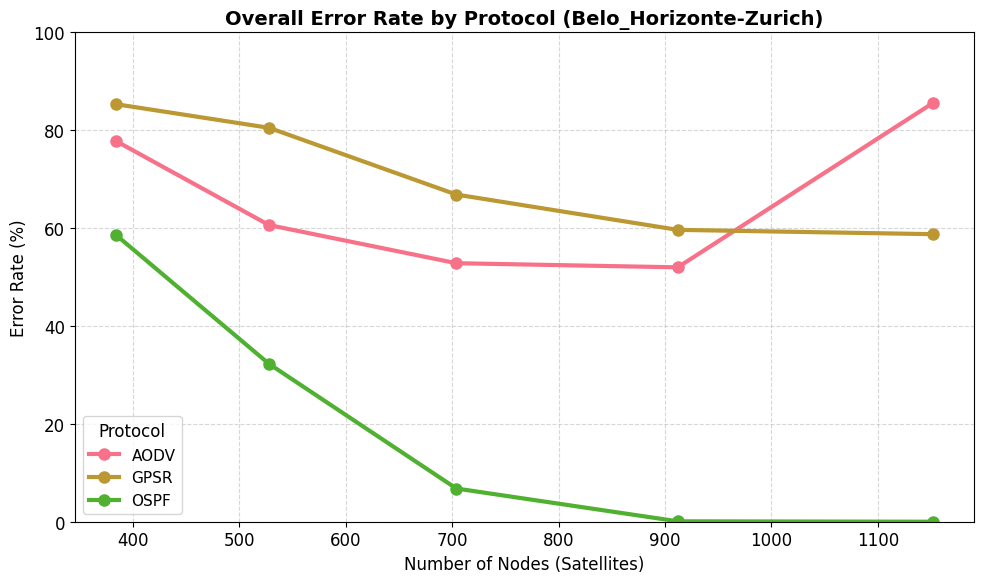

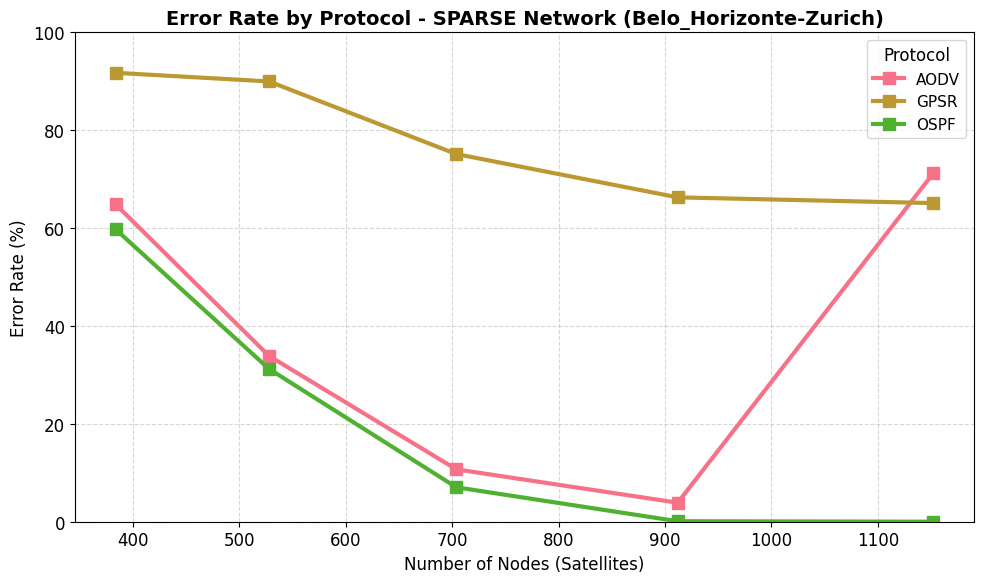

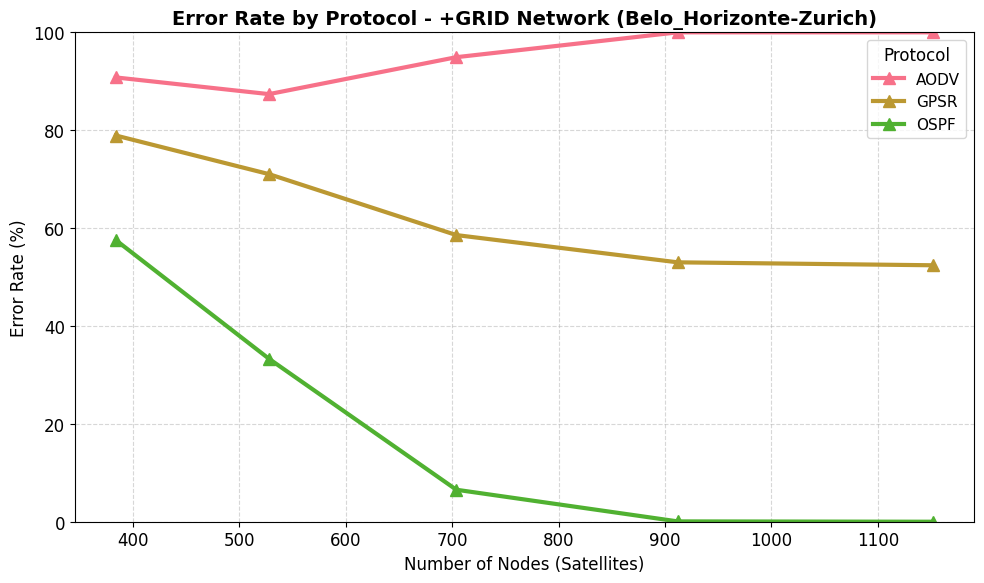

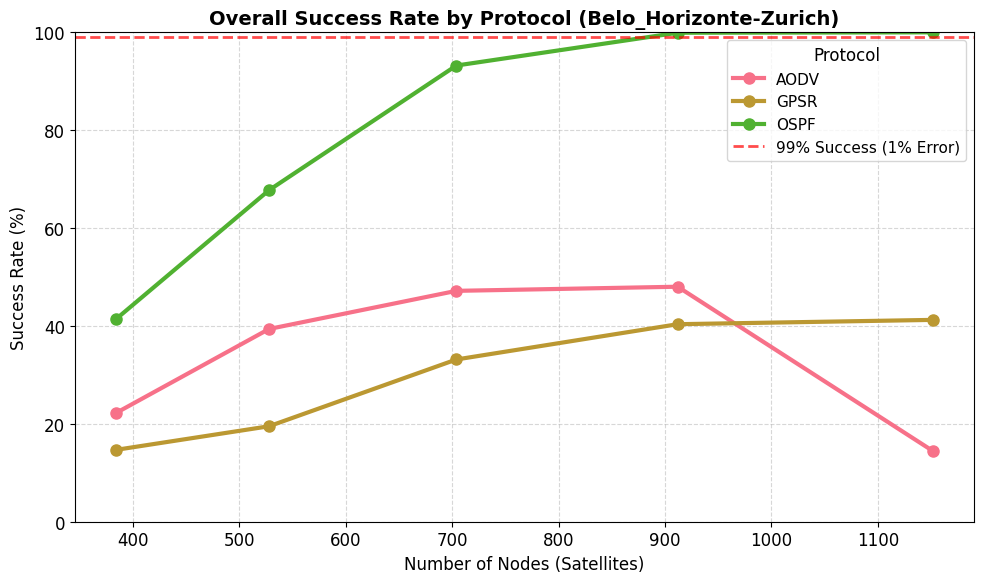

In [113]:
# Create individual plots showing error rate vs. number of nodes
print("📊 INDIVIDUAL PLOTS - ERROR RATE VS. NUMBER OF NODES")
print("=" * 60)

# Prepare data for plotting
overall_error = (
    bh_zurich.groupby(['protocol', 'num_nodes'])['route_success']
    .agg(['count', 'sum'])
    .reset_index()
)
overall_error['error_rate'] = 1 - (overall_error['sum'] / overall_error['count'])
pivot_overall = overall_error.pivot(index='num_nodes', columns='protocol', values='error_rate')

# Plot 1: Overall error rate by protocol (combining both network designs)
plt.figure(figsize=(10, 6))
for protocol in pivot_overall.columns:
    plt.plot(pivot_overall.index, pivot_overall[protocol] * 100, marker='o', linewidth=3, markersize=8, label=protocol)
plt.xlabel('Number of Nodes (Satellites)', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.title('Overall Error Rate by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Protocol', fontsize=11)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot 2: Error rate by protocol for SPARSE network design
plt.figure(figsize=(10, 6))
sparse_data = error_rate_summary[error_rate_summary['network_design_clean'] == 'SPARSE']
if not sparse_data.empty:
    pivot_sparse = sparse_data.pivot(index='num_nodes', columns='protocol', values='error_rate')
    for protocol in pivot_sparse.columns:
        plt.plot(pivot_sparse.index, pivot_sparse[protocol] * 100, marker='s', linewidth=3, markersize=8, label=protocol)
plt.xlabel('Number of Nodes (Satellites)', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.title('Error Rate by Protocol - SPARSE Network (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Protocol', fontsize=11)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot 3: Error rate by protocol for +GRID network design
plt.figure(figsize=(10, 6))
grid_data = error_rate_summary[error_rate_summary['network_design_clean'] == '+GRID']
if not grid_data.empty:
    pivot_grid = grid_data.pivot(index='num_nodes', columns='protocol', values='error_rate')
    for protocol in pivot_grid.columns:
        plt.plot(pivot_grid.index, pivot_grid[protocol] * 100, marker='^', linewidth=3, markersize=8, label=protocol)
plt.xlabel('Number of Nodes (Satellites)', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.title('Error Rate by Protocol - +GRID Network (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Protocol', fontsize=11)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot 4: Success rate comparison (complement of error rate)
plt.figure(figsize=(10, 6))
for protocol in pivot_overall.columns:
    plt.plot(pivot_overall.index, (1 - pivot_overall[protocol]) * 100, marker='o', linewidth=3, markersize=8, label=protocol)
# Add horizontal line at 99% success rate (1% error rate)
plt.axhline(y=99, color='red', linestyle='--', alpha=0.7, linewidth=2, label='99% Success (1% Error)')
plt.xlabel('Number of Nodes (Satellites)', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Overall Success Rate by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Protocol', fontsize=11)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [114]:
# Analyze minimum number of nodes for <1% error rate or lowest error rate achieved
print("🎯 MINIMUM NUMBER OF NODES ANALYSIS")
print("=" * 50)

print("\n📊 OVERALL ANALYSIS (combining both network designs):")
print("-" * 50)

# Overall analysis
for protocol in pivot_overall.columns:
    protocol_data = pivot_overall[protocol].dropna()
    below_1pct = protocol_data[protocol_data < 0.01]
    
    if not below_1pct.empty:
        min_nodes = below_1pct.index[0]
        min_error = below_1pct.iloc[0]
        print(f"✅ {protocol}: {min_nodes} nodes (error rate: {min_error:.3%})")
    else:
        min_error = protocol_data.min()
        min_nodes = protocol_data.idxmin()
        print(f"❌ {protocol}: Never <1% error rate")
        print(f"   └─ Lowest error rate: {min_error:.1%} at {min_nodes} nodes")

print("\n📊 NETWORK DESIGN SPECIFIC ANALYSIS:")
print("-" * 50)

# Analysis by network design
for network_design in ['SPARSE', '+GRID']:
    print(f"\n🌐 {network_design} Network Design:")
    print("-" * 30)
    
    design_data = error_rate_summary[error_rate_summary['network_design_clean'] == network_design]
    if design_data.empty:
        print(f"   No data available for {network_design}")
        continue
        
    pivot_design = design_data.pivot(index='num_nodes', columns='protocol', values='error_rate')
    
    for protocol in pivot_design.columns:
        protocol_data = pivot_design[protocol].dropna()
        below_1pct = protocol_data[protocol_data < 0.01]
        
        if not below_1pct.empty:
            min_nodes = below_1pct.index[0]
            min_error = below_1pct.iloc[0]
            print(f"✅ {protocol}: {min_nodes} nodes (error rate: {min_error:.3%})")
        else:
            min_error = protocol_data.min()
            min_nodes = protocol_data.idxmin()
            print(f"❌ {protocol}: Never <1% error rate")
            print(f"   └─ Lowest error rate: {min_error:.1%} at {min_nodes} nodes")


🎯 MINIMUM NUMBER OF NODES ANALYSIS

📊 OVERALL ANALYSIS (combining both network designs):
--------------------------------------------------
❌ AODV: Never <1% error rate
   └─ Lowest error rate: 52.0% at 912 nodes
❌ GPSR: Never <1% error rate
   └─ Lowest error rate: 58.8% at 1152 nodes
✅ OSPF: 912 nodes (error rate: 0.083%)

📊 NETWORK DESIGN SPECIFIC ANALYSIS:
--------------------------------------------------

🌐 SPARSE Network Design:
------------------------------
❌ AODV: Never <1% error rate
   └─ Lowest error rate: 3.9% at 912 nodes
❌ GPSR: Never <1% error rate
   └─ Lowest error rate: 65.1% at 1152 nodes
✅ OSPF: 912 nodes (error rate: 0.100%)

🌐 +GRID Network Design:
------------------------------
❌ AODV: Never <1% error rate
   └─ Lowest error rate: 87.4% at 528 nodes
❌ GPSR: Never <1% error rate
   └─ Lowest error rate: 52.4% at 1152 nodes
✅ OSPF: 912 nodes (error rate: 0.067%)


In [115]:
# Create a detailed summary table
print("\n📋 DETAILED SUMMARY TABLE")
print("=" * 50)

# Create comprehensive summary
summary_table = []

for network_design in ['SPARSE', '+GRID', 'OVERALL']:
    if network_design == 'OVERALL':
        pivot_data = pivot_overall
    else:
        design_data = error_rate_summary[error_rate_summary['network_design_clean'] == network_design]
        if design_data.empty:
            continue
        pivot_data = design_data.pivot(index='num_nodes', columns='protocol', values='error_rate')
    
    for protocol in pivot_data.columns:
        protocol_data = pivot_data[protocol].dropna()
        
        # Find minimum error rate
        min_error = protocol_data.min()
        min_nodes_for_min_error = protocol_data.idxmin()
        
        # Check if <1% is achieved
        below_1pct = protocol_data[protocol_data < 0.01]
        if not below_1pct.empty:
            min_nodes_1pct = below_1pct.index[0]
            achieves_1pct = 'Yes'
        else:
            min_nodes_1pct = 'N/A'
            achieves_1pct = 'No'
        
        summary_table.append({
            'Network_Design': network_design,
            'Protocol': protocol,
            'Min_Error_Rate': f'{min_error:.1%}',
            'Nodes_for_Min_Error': min_nodes_for_min_error,
            'Achieves_1pct_Error': achieves_1pct,
            'Min_Nodes_for_1pct': min_nodes_1pct
        })

summary_df = pd.DataFrame(summary_table)
display(summary_df)



📋 DETAILED SUMMARY TABLE


,Network_Design,Protocol,Min_Error_Rate,Nodes_for_Min_Error,Achieves_1pct_Error,Min_Nodes_for_1pct
0,SPARSE,AODV,3.9%,912,No,N/A
1,SPARSE,GPSR,65.1%,1152,No,N/A
2,SPARSE,OSPF,0.0%,1152,Yes,912
3,+GRID,AODV,87.4%,528,No,N/A
4,+GRID,GPSR,52.4%,1152,No,N/A
5,+GRID,OSPF,0.0%,1152,Yes,912
6,OVERALL,AODV,52.0%,912,No,N/A
7,OVERALL,GPSR,58.8%,1152,No,N/A
8,OVERALL,OSPF,0.0%,1152,Yes,912


In [116]:
# Filter for successful routes only (Belo_Horizonte to Zurich)
print("🔍 ROUTE STABILITY ANALYSIS - SUCCESSFUL ROUTES ONLY")
print("=" * 60)

# Filter for successful routes from Belo_Horizonte to Zurich
successful_bh_zurich = bh_zurich[bh_zurich['route_success'] == True].copy()

print(f"📊 Total successful routes for analysis: {len(successful_bh_zurich):,}")
print(f"🎯 Protocols in successful routes: {sorted(successful_bh_zurich['protocol'].unique())}")
print(f"🛰️  Node counts in successful routes: {sorted(successful_bh_zurich['num_nodes'].unique())}")
print(f"🌐 Network designs in successful routes: {sorted(successful_bh_zurich['network_design_clean'].unique())}")

# Basic statistics for successful routes
print(f"\n📈 Success rate by protocol:")
print("-" * 30)
success_by_protocol = successful_bh_zurich.groupby('protocol').agg({
    'num_hops': ['count', 'mean', 'std'],
    'total_distance': ['mean', 'std'],
    'time_taken_us': ['mean', 'std']
}).round(2)

success_by_protocol.columns = ['Count', 'Avg_Hops', 'Std_Hops', 'Avg_Distance', 'Std_Distance', 'Avg_Time', 'Std_Time']
display(success_by_protocol)

# Prepare data for detailed analysis
print(f"\n🔬 Preparing data for stability analysis...")
successful_bh_zurich['timestamp_hours'] = successful_bh_zurich['timestamp'] / 3600  # Convert to hours
successful_bh_zurich['route_path_str'] = successful_bh_zurich['route_path'].astype(str)


🔍 ROUTE STABILITY ANALYSIS - SUCCESSFUL ROUTES ONLY
📊 Total successful routes for analysis: 43,300
🎯 Protocols in successful routes: ['AODV', 'GPSR', 'OSPF']
🛰️  Node counts in successful routes: [384, 528, 704, 912, 1152]
🌐 Network designs in successful routes: ['+GRID', 'SPARSE']

📈 Success rate by protocol:
------------------------------


,Count,Avg_Hops,Std_Hops,Avg_Distance,Std_Distance,Avg_Time,Std_Time
protocol,,,,,,,
AODV,10246,9.00,1.57,12626534.54,2342773.60,403.49,2275.00
GPSR,8931,11.49,9.23,15704789.48,12800123.84,49.05,29.95
OSPF,24123,9.23,1.52,12143826.35,1877987.58,332.31,1526.18



🔬 Preparing data for stability analysis...


📊 ANALYSIS 1: NUMBER OF HOPS VARIATION
📋 Hop Count Statistics by Protocol and Network Design:


,protocol,network_design_clean,num_nodes,Mean_Hops,Std_Hops,Min_Hops,Max_Hops,Count,CV_Hops
0,AODV,+GRID,384,6.094,0.293,6,7,276,0.048
1,AODV,+GRID,528,6.910,0.286,6,7,378,0.041
2,AODV,+GRID,704,7.000,0.000,7,7,152,0.000
3,AODV,SPARSE,384,9.107,2.413,6,22,1053,0.265
4,AODV,SPARSE,528,9.303,1.806,6,19,1981,0.194
5,AODV,SPARSE,704,9.062,1.338,7,15,2671,0.148
6,AODV,SPARSE,912,9.335,0.964,8,12,2872,0.103
7,AODV,SPARSE,1152,9.092,0.308,9,11,863,0.034
8,GPSR,+GRID,384,7.505,1.554,6,12,632,0.207
9,GPSR,+GRID,528,7.880,1.769,6,15,869,0.224


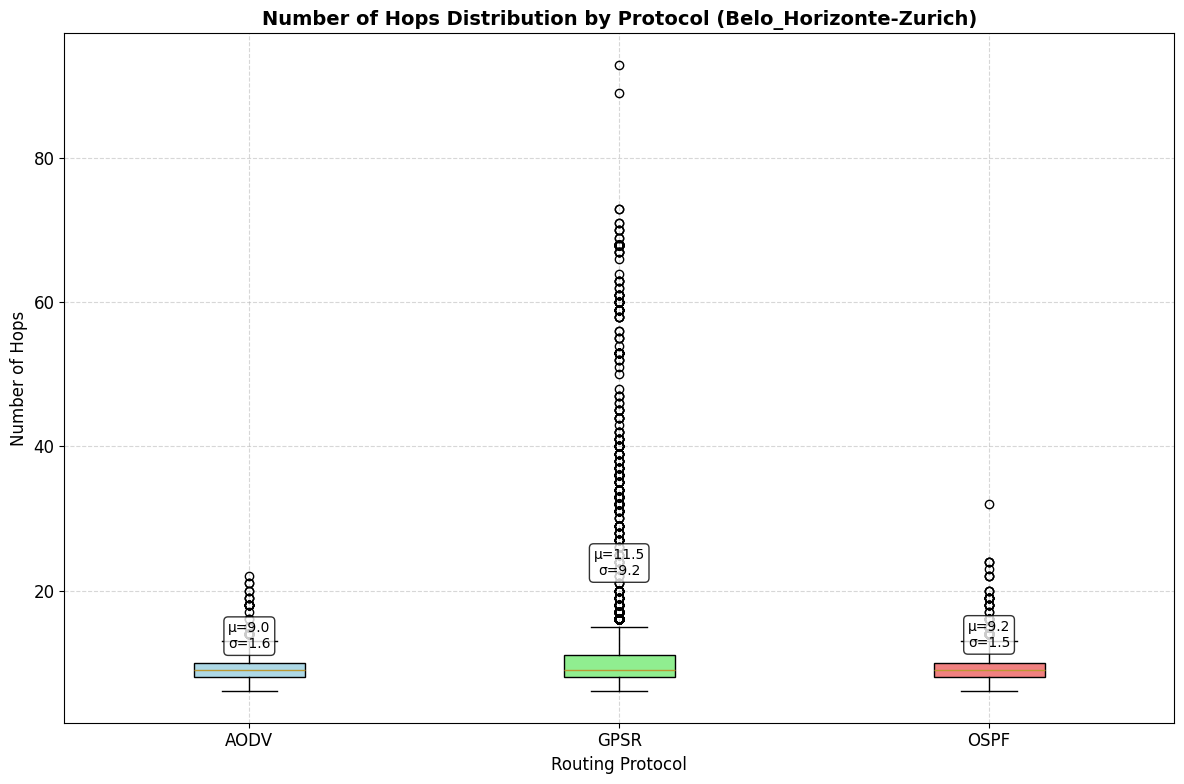

In [117]:
# 1. ANALYSIS: Number of Hops Variation
print("📊 ANALYSIS 1: NUMBER OF HOPS VARIATION")
print("=" * 50)

# Calculate hop count statistics by protocol and network design
hop_stats = successful_bh_zurich.groupby(['protocol', 'network_design_clean', 'num_nodes']).agg({
    'num_hops': ['mean', 'std', 'min', 'max', 'count']
}).round(3)
hop_stats.columns = ['Mean_Hops', 'Std_Hops', 'Min_Hops', 'Max_Hops', 'Count']
hop_stats['CV_Hops'] = (hop_stats['Std_Hops'] / hop_stats['Mean_Hops']).round(3)  # Coefficient of Variation
hop_stats = hop_stats.reset_index()

print("📋 Hop Count Statistics by Protocol and Network Design:")
display(hop_stats.head(15))

# Plot 1: Hop Count Variation by Protocol
plt.figure(figsize=(12, 8))

# Create box plots for hop count distribution
protocols = successful_bh_zurich['protocol'].unique()
positions = np.arange(len(protocols))

hop_data = [successful_bh_zurich[successful_bh_zurich['protocol'] == p]['num_hops'] for p in protocols]

box_plot = plt.boxplot(hop_data, positions=positions, labels=protocols, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Routing Protocol', fontsize=12)
plt.ylabel('Number of Hops', fontsize=12)
plt.title('Number of Hops Distribution by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Add statistics annotations
for i, protocol in enumerate(protocols):
    data = successful_bh_zurich[successful_bh_zurich['protocol'] == protocol]['num_hops']
    mean_val = data.mean()
    std_val = data.std()
    plt.text(i, mean_val + std_val + 1, f'μ={mean_val:.1f}\nσ={std_val:.1f}', 
             ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


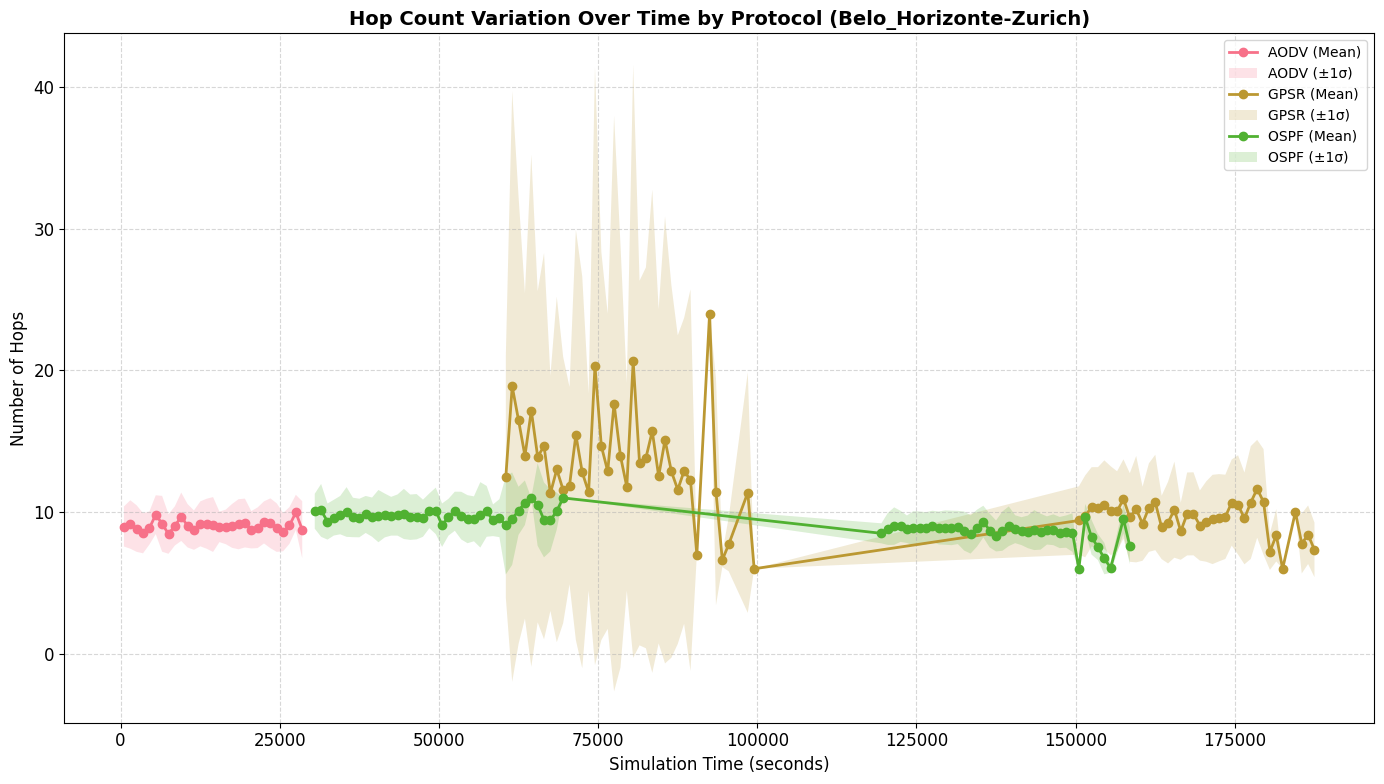

In [118]:
# Plot 2: Hop Count Variation Over Time by Protocol
plt.figure(figsize=(14, 8))

# Create time-based analysis (using timestamp)
for protocol in protocols:
    protocol_data = successful_bh_zurich[successful_bh_zurich['protocol'] == protocol]
    
    # Group by time windows (every 1000 seconds) to see trends
    time_bins = np.arange(protocol_data['timestamp'].min(), protocol_data['timestamp'].max(), 1000)
    protocol_data['time_bin'] = pd.cut(protocol_data['timestamp'], bins=time_bins)
    
    # Calculate mean and std for each time bin
    time_stats = protocol_data.groupby('time_bin')['num_hops'].agg(['mean', 'std']).dropna()
    
    if not time_stats.empty:
        # Use the midpoint of each bin for plotting
        x_values = [interval.mid for interval in time_stats.index]
        plt.plot(x_values, time_stats['mean'], marker='o', label=f'{protocol} (Mean)', linewidth=2)
        plt.fill_between(x_values, 
                        time_stats['mean'] - time_stats['std'], 
                        time_stats['mean'] + time_stats['std'], 
                        alpha=0.2, label=f'{protocol} (±1σ)')

plt.xlabel('Simulation Time (seconds)', fontsize=12)
plt.ylabel('Number of Hops', fontsize=12)
plt.title('Hop Count Variation Over Time by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


📊 ANALYSIS 2: DISTANCE VARIATION
📋 Distance Statistics by Protocol and Network Design:


,protocol,network_design_clean,num_nodes,Mean_Distance,Std_Distance,Min_Distance,Max_Distance,Count,CV_Distance
0,AODV,+GRID,384,11737704.0,511557.0,10838283,12514299,276,0.044
1,AODV,+GRID,528,11591019.0,585396.0,10341056,12549588,378,0.051
2,AODV,+GRID,704,10558591.0,48719.0,10500560,10753426,152,0.005
3,AODV,SPARSE,384,15364299.0,3964239.0,10809303,39760721,1053,0.258
4,AODV,SPARSE,528,14031531.0,2677972.0,10341056,32955516,1981,0.191
5,AODV,SPARSE,704,12314949.0,1467289.0,10500550,20783505,2671,0.119
6,AODV,SPARSE,912,11766954.0,765984.0,10652434,15366413,2872,0.065
7,AODV,SPARSE,1152,10987910.0,321473.0,10788584,12449053,863,0.029
8,GPSR,+GRID,384,14715652.0,3926267.0,10807935,22659772,632,0.267
9,GPSR,+GRID,528,13381747.0,3260351.0,10340547,23292979,869,0.244


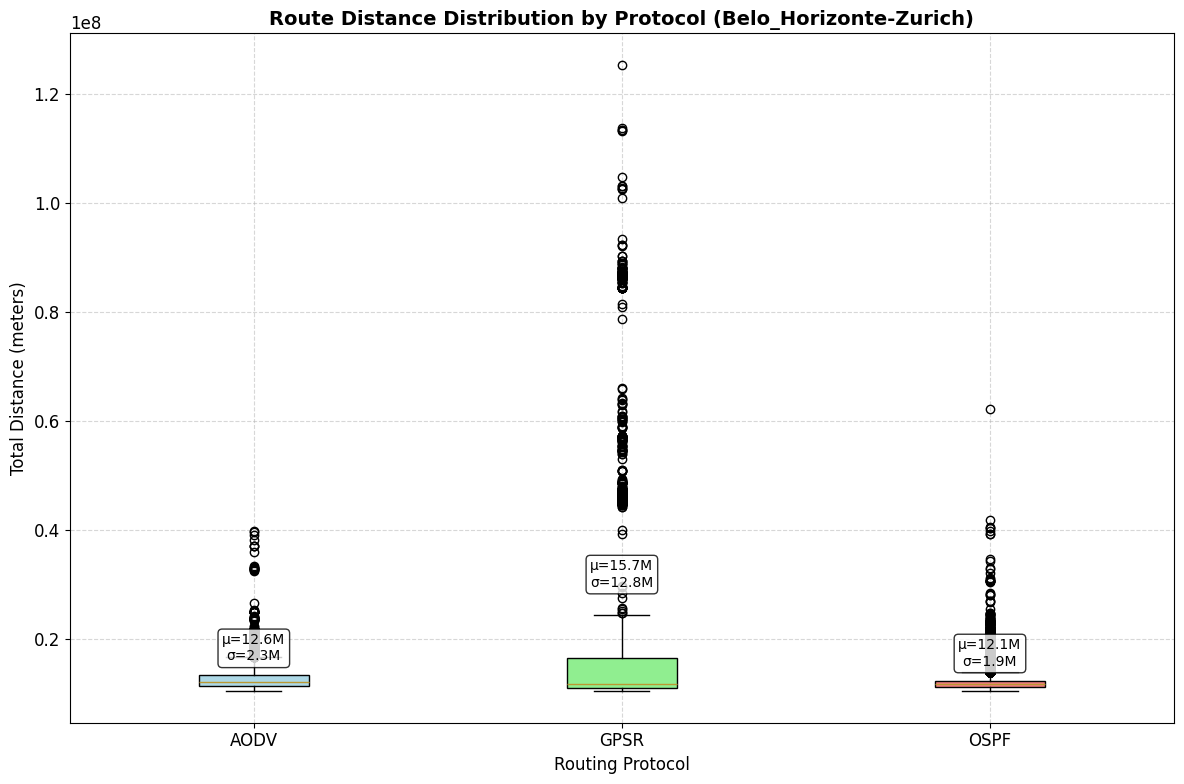

In [119]:
# 2. ANALYSIS: Distance Variation
print("📊 ANALYSIS 2: DISTANCE VARIATION")
print("=" * 50)

# Calculate distance statistics by protocol
distance_stats = successful_bh_zurich.groupby(['protocol', 'network_design_clean', 'num_nodes']).agg({
    'total_distance': ['mean', 'std', 'min', 'max', 'count']
}).round(0)
distance_stats.columns = ['Mean_Distance', 'Std_Distance', 'Min_Distance', 'Max_Distance', 'Count']
distance_stats['CV_Distance'] = (distance_stats['Std_Distance'] / distance_stats['Mean_Distance']).round(3)
distance_stats = distance_stats.reset_index()

print("📋 Distance Statistics by Protocol and Network Design:")
display(distance_stats.head(15))

# Plot 3: Distance Variation by Protocol
plt.figure(figsize=(12, 8))

# Create box plots for distance distribution
distance_data = [successful_bh_zurich[successful_bh_zurich['protocol'] == p]['total_distance'] for p in protocols]

box_plot = plt.boxplot(distance_data, positions=positions, labels=protocols, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Routing Protocol', fontsize=12)
plt.ylabel('Total Distance (meters)', fontsize=12)
plt.title('Route Distance Distribution by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Format y-axis to show distances in a readable format
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Add statistics annotations
for i, protocol in enumerate(protocols):
    data = successful_bh_zurich[successful_bh_zurich['protocol'] == protocol]['total_distance']
    mean_val = data.mean()
    std_val = data.std()
    plt.text(i, mean_val + std_val + 500000, f'μ={mean_val/1e6:.1f}M\nσ={std_val/1e6:.1f}M', 
             ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


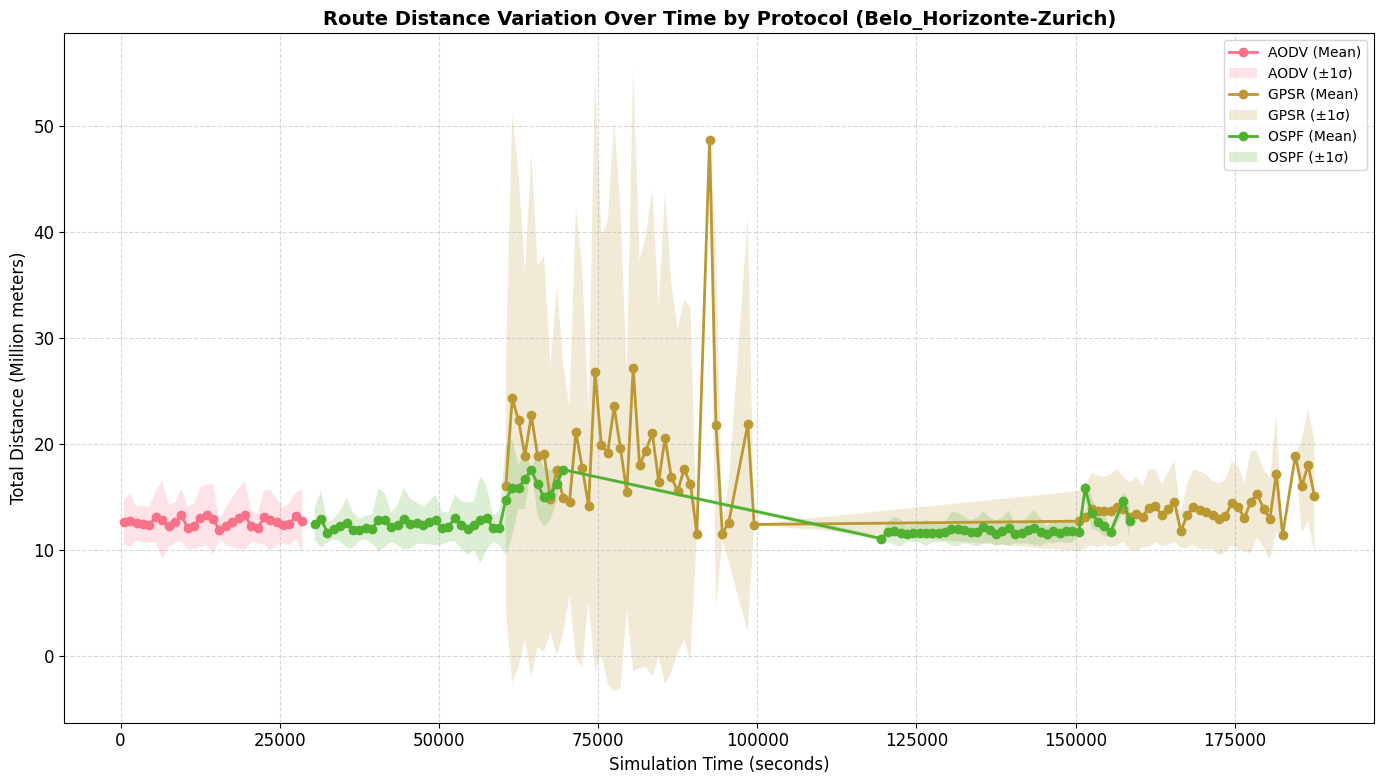

In [120]:
# Plot 4: Distance Variation Over Time by Protocol
plt.figure(figsize=(14, 8))

# Create time-based distance analysis
for protocol in protocols:
    protocol_data = successful_bh_zurich[successful_bh_zurich['protocol'] == protocol]
    
    # Group by time windows (every 1000 seconds)
    time_bins = np.arange(protocol_data['timestamp'].min(), protocol_data['timestamp'].max(), 1000)
    protocol_data['time_bin'] = pd.cut(protocol_data['timestamp'], bins=time_bins)
    
    # Calculate mean and std for each time bin
    time_stats = protocol_data.groupby('time_bin')['total_distance'].agg(['mean', 'std']).dropna()
    
    if not time_stats.empty:
        # Use the midpoint of each bin for plotting
        x_values = [interval.mid for interval in time_stats.index]
        plt.plot(x_values, time_stats['mean']/1e6, marker='o', label=f'{protocol} (Mean)', linewidth=2)
        plt.fill_between(x_values, 
                        (time_stats['mean'] - time_stats['std'])/1e6, 
                        (time_stats['mean'] + time_stats['std'])/1e6, 
                        alpha=0.2, label=f'{protocol} (±1σ)')

plt.xlabel('Simulation Time (seconds)', fontsize=12)
plt.ylabel('Total Distance (Million meters)', fontsize=12)
plt.title('Route Distance Variation Over Time by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [121]:
# 3. ANALYSIS: Path Stability (Route Changes)
print("📊 ANALYSIS 3: PATH STABILITY (ROUTE CHANGES)")
print("=" * 50)

# Function to calculate path changes
def calculate_path_changes(df):
    """Calculate the number of unique paths and path change frequency"""
    df_sorted = df.sort_values('timestamp')
    unique_paths = df_sorted['route_path_str'].nunique()
    total_routes = len(df_sorted)
    
    # Calculate consecutive path changes
    path_changes = 0
    prev_path = None
    for current_path in df_sorted['route_path_str']:
        if prev_path is not None and current_path != prev_path:
            path_changes += 1
        prev_path = current_path
    
    change_frequency = path_changes / total_routes if total_routes > 0 else 0
    path_diversity = unique_paths / total_routes if total_routes > 0 else 0
    
    return {
        'total_routes': total_routes,
        'unique_paths': unique_paths,
        'path_changes': path_changes,
        'change_frequency': change_frequency,
        'path_diversity': path_diversity
    }

# Calculate path stability metrics by protocol and network design
path_stability_results = []

for protocol in protocols:
    for network_design in successful_bh_zurich['network_design_clean'].unique():
        for num_nodes in successful_bh_zurich['num_nodes'].unique():
            subset = successful_bh_zurich[
                (successful_bh_zurich['protocol'] == protocol) & 
                (successful_bh_zurich['network_design_clean'] == network_design) &
                (successful_bh_zurich['num_nodes'] == num_nodes)
            ]
            
            if len(subset) > 0:
                stability_metrics = calculate_path_changes(subset)
                stability_metrics.update({
                    'protocol': protocol,
                    'network_design': network_design,
                    'num_nodes': num_nodes
                })
                path_stability_results.append(stability_metrics)

path_stability_df = pd.DataFrame(path_stability_results)
print("📋 Path Stability Metrics by Protocol:")
display(path_stability_df.round(3))


📊 ANALYSIS 3: PATH STABILITY (ROUTE CHANGES)
📋 Path Stability Metrics by Protocol:


,total_routes,unique_paths,path_changes,change_frequency,path_diversity,protocol,network_design,num_nodes
0,2671,942,952,0.356,0.353,AODV,SPARSE,704
1,863,181,180,0.209,0.210,AODV,SPARSE,1152
2,2872,805,829,0.289,0.280,AODV,SPARSE,912
3,1981,897,920,0.464,0.453,AODV,SPARSE,528
4,1053,413,413,0.392,0.392,AODV,SPARSE,384
5,152,41,40,0.263,0.270,AODV,+GRID,704
6,378,122,121,0.320,0.323,AODV,+GRID,528
7,276,74,73,0.264,0.268,AODV,+GRID,384
8,746,331,331,0.444,0.444,GPSR,SPARSE,704
9,1046,527,564,0.539,0.504,GPSR,SPARSE,1152


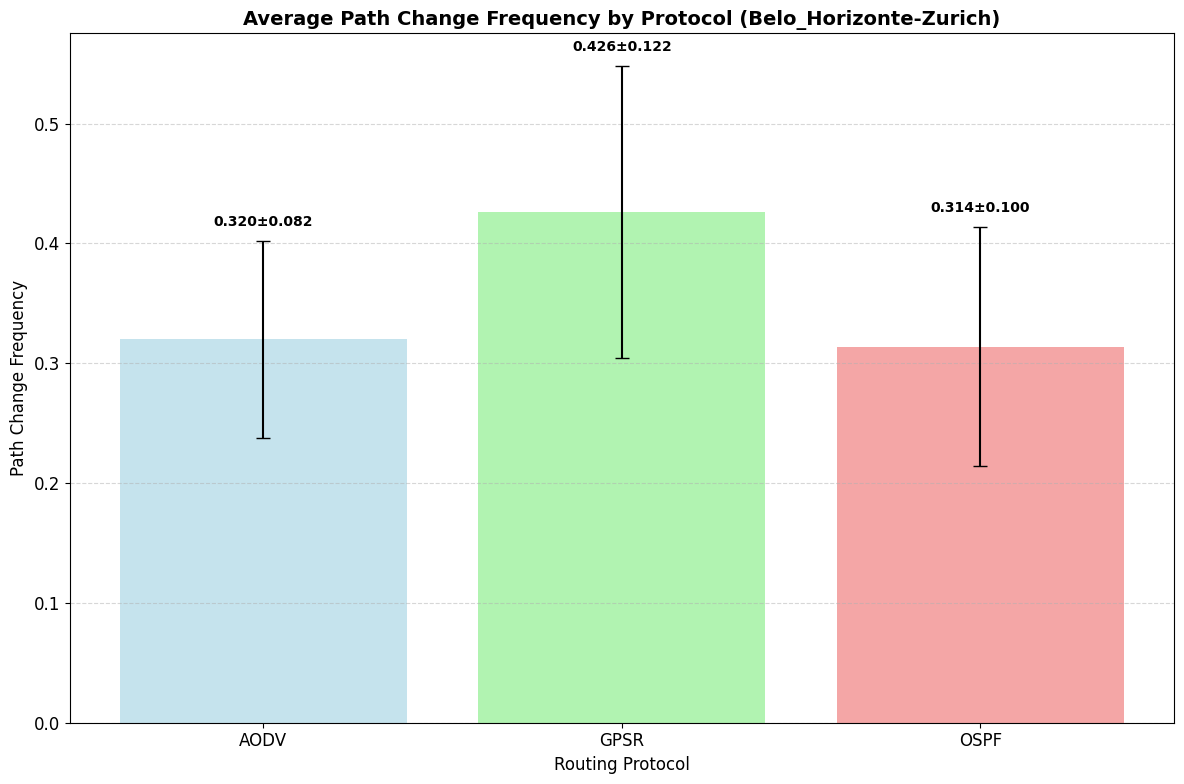

📊 Protocol Stability Summary:


,protocol,Mean_Change_Freq,Std_Change_Freq,Mean_Path_Diversity,Std_Path_Diversity
0,AODV,0.320,0.082,0.319,0.078
1,GPSR,0.426,0.122,0.418,0.116
2,OSPF,0.314,0.100,0.309,0.098


In [122]:
# Plot 5: Path Change Frequency by Protocol
plt.figure(figsize=(12, 8))

# Aggregate path stability by protocol
protocol_stability = path_stability_df.groupby('protocol').agg({
    'change_frequency': ['mean', 'std'],
    'path_diversity': ['mean', 'std']
}).round(3)

protocol_stability.columns = ['Mean_Change_Freq', 'Std_Change_Freq', 'Mean_Path_Diversity', 'Std_Path_Diversity']
protocol_stability = protocol_stability.reset_index()

# Create bar plot for change frequency
x_pos = np.arange(len(protocol_stability))
plt.bar(x_pos, protocol_stability['Mean_Change_Freq'], 
        yerr=protocol_stability['Std_Change_Freq'],
        capsize=5, alpha=0.7, color=['lightblue', 'lightgreen', 'lightcoral'])

plt.xlabel('Routing Protocol', fontsize=12)
plt.ylabel('Path Change Frequency', fontsize=12)
plt.title('Average Path Change Frequency by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, protocol_stability['protocol'])
plt.grid(True, linestyle='--', alpha=0.5, axis='y')

# Add value labels on bars
for i, (freq, std) in enumerate(zip(protocol_stability['Mean_Change_Freq'], protocol_stability['Std_Change_Freq'])):
    plt.text(i, freq + std + 0.01, f'{freq:.3f}±{std:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Protocol Stability Summary:")
display(protocol_stability)


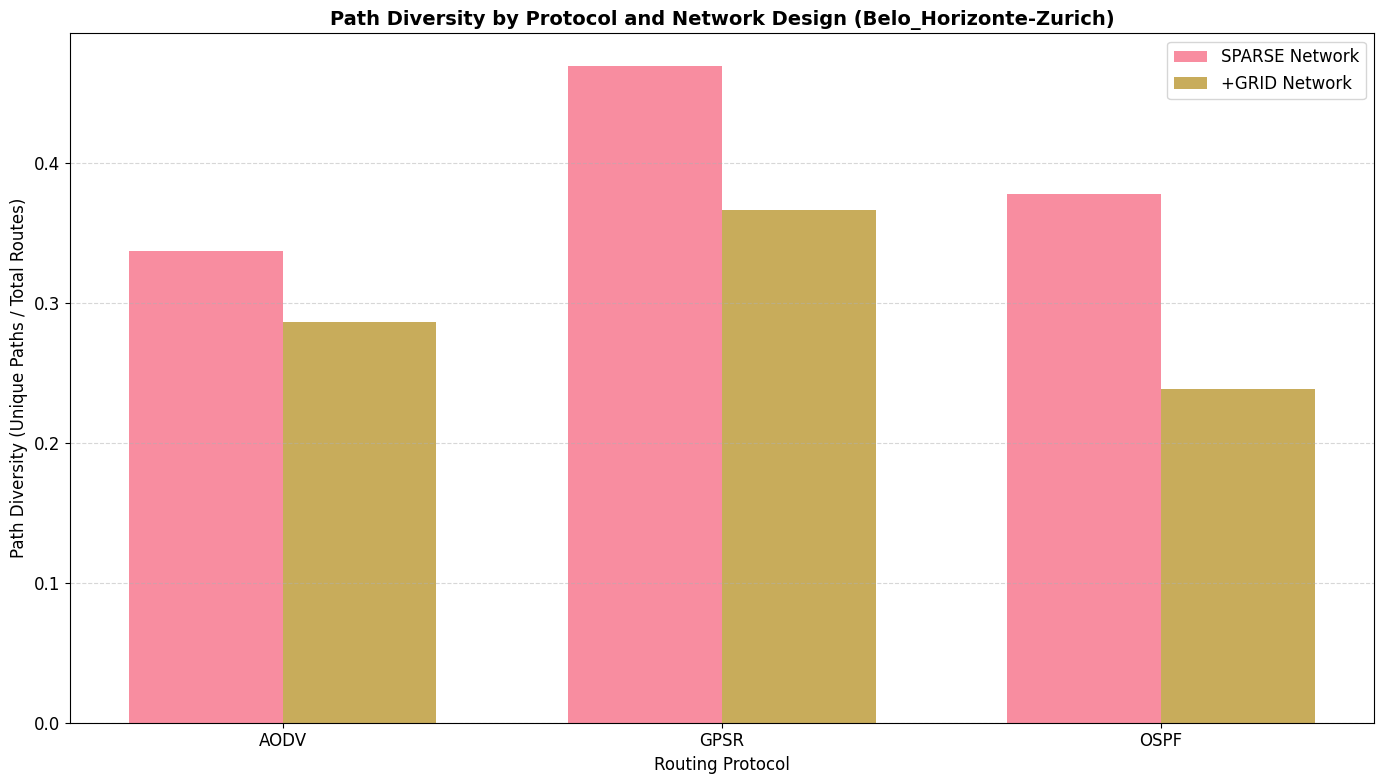

In [123]:
# Plot 6: Path Diversity by Protocol and Network Design
plt.figure(figsize=(14, 8))

# Create grouped bar chart for path diversity
network_designs = path_stability_df['network_design'].unique()
protocols = path_stability_df['protocol'].unique()

x = np.arange(len(protocols))
width = 0.35

for i, network_design in enumerate(network_designs):
    design_data = path_stability_df[path_stability_df['network_design'] == network_design]
    diversity_by_protocol = design_data.groupby('protocol')['path_diversity'].mean()
    
    plt.bar(x + i*width, diversity_by_protocol, width, 
            label=f'{network_design} Network', alpha=0.8)

plt.xlabel('Routing Protocol', fontsize=12)
plt.ylabel('Path Diversity (Unique Paths / Total Routes)', fontsize=12)
plt.title('Path Diversity by Protocol and Network Design (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.xticks(x + width/2, protocols)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()


In [124]:
# Comprehensive Stability Comparison
print("🏆 COMPREHENSIVE ROUTE STABILITY COMPARISON")
print("=" * 60)

# Create overall stability ranking
stability_summary = []

for protocol in protocols:
    protocol_data = successful_bh_zurich[successful_bh_zurich['protocol'] == protocol]
    
    # Calculate overall metrics
    hop_cv = protocol_data['num_hops'].std() / protocol_data['num_hops'].mean()
    distance_cv = protocol_data['total_distance'].std() / protocol_data['total_distance'].mean()
    
    # Get path stability metrics
    protocol_path_stats = path_stability_df[path_stability_df['protocol'] == protocol]
    avg_change_freq = protocol_path_stats['change_frequency'].mean()
    avg_path_diversity = protocol_path_stats['path_diversity'].mean()
    
    stability_summary.append({
        'Protocol': protocol,
        'Hop_Count_CV': hop_cv,
        'Distance_CV': distance_cv,
        'Path_Change_Frequency': avg_change_freq,
        'Path_Diversity': avg_path_diversity,
        'Stability_Score': (1 - hop_cv) + (1 - distance_cv) + (1 - avg_change_freq)  # Higher is better
    })

stability_comparison = pd.DataFrame(stability_summary).round(4)
stability_comparison = stability_comparison.sort_values('Stability_Score', ascending=False)

print("📊 Route Stability Ranking (Higher Stability Score = More Stable):")
print("=" * 60)
display(stability_comparison)

# Determine the most stable protocol
most_stable = stability_comparison.iloc[0]['Protocol']
print(f"\n🏅 WINNER: {most_stable} shows the highest route stability!")
print(f"   - Lowest hop count variation (CV: {stability_comparison.iloc[0]['Hop_Count_CV']:.4f})")
print(f"   - Lowest distance variation (CV: {stability_comparison.iloc[0]['Distance_CV']:.4f})")
print(f"   - Lowest path change frequency: {stability_comparison.iloc[0]['Path_Change_Frequency']:.4f}")
print(f"   - Overall stability score: {stability_comparison.iloc[0]['Stability_Score']:.4f}")

print(f"\n📈 Key Insights:")
print("-" * 30)
for i, row in stability_comparison.iterrows():
    protocol = row['Protocol']
    if i == 0:
        print(f"🥇 {protocol}: Most stable - generates fewer route changes")
    elif i == 1:
        print(f"🥈 {protocol}: Moderate stability")
    else:
        print(f"🥉 {protocol}: Least stable - generates more route changes")


🏆 COMPREHENSIVE ROUTE STABILITY COMPARISON
📊 Route Stability Ranking (Higher Stability Score = More Stable):


,Protocol,Hop_Count_CV,Distance_CV,Path_Change_Frequency,Path_Diversity,Stability_Score
2,OSPF,0.1643,0.1546,0.3139,0.3087,2.3671
0,AODV,0.1745,0.1855,0.3198,0.3185,2.3202
1,GPSR,0.8039,0.8150,0.4262,0.4179,0.9548



🏅 WINNER: OSPF shows the highest route stability!
   - Lowest hop count variation (CV: 0.1643)
   - Lowest distance variation (CV: 0.1546)
   - Lowest path change frequency: 0.3139
   - Overall stability score: 2.3671

📈 Key Insights:
------------------------------
🥉 OSPF: Least stable - generates more route changes
🥇 AODV: Most stable - generates fewer route changes
🥈 GPSR: Moderate stability


In [125]:
# Algorithm Performance Analysis - Execution Time
print("⚡ ALGORITHM PERFORMANCE ANALYSIS - EXECUTION TIME")
print("=" * 60)

# Use the original bh_zurich dataset (includes all routes - successful and failed)
print(f"📊 Total routes for performance analysis: {len(bh_zurich):,}")
print(f"🎯 Protocols analyzed: {sorted(bh_zurich['protocol'].unique())}")
print(f"✅ Successful routes: {bh_zurich['route_success'].sum():,} ({bh_zurich['route_success'].mean()*100:.1f}%)")
print(f"❌ Failed routes: {(~bh_zurich['route_success']).sum():,} ({(~bh_zurich['route_success']).mean()*100:.1f}%)")

# Clean execution time data (remove any invalid values)
bh_zurich_clean = bh_zurich[bh_zurich['time_taken_us'] >= 0].copy()
print(f"📈 Valid execution time records: {len(bh_zurich_clean):,}")

# Calculate comprehensive performance statistics
performance_stats = bh_zurich_clean.groupby(['protocol', 'route_success']).agg({
    'time_taken_us': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'num_nodes': 'mean'
}).round(2)

performance_stats.columns = ['Count', 'Mean_Time', 'Median_Time', 'Std_Time', 'Min_Time', 'Max_Time', 'Avg_Nodes']
performance_stats = performance_stats.reset_index()

print(f"\n📋 Performance Statistics by Protocol and Success Status:")
print("-" * 60)
display(performance_stats)

# Overall performance by protocol (all routes combined)
overall_performance = bh_zurich_clean.groupby('protocol').agg({
    'time_taken_us': ['count', 'mean', 'median', 'std'],
    'route_success': 'mean'
}).round(3)

overall_performance.columns = ['Total_Routes', 'Mean_Time_us', 'Median_Time_us', 'Std_Time_us', 'Success_Rate']
overall_performance = overall_performance.reset_index()
overall_performance['CV_Time'] = (overall_performance['Std_Time_us'] / overall_performance['Mean_Time_us']).round(3)

print(f"\n🏆 Overall Algorithm Performance Summary:")
print("-" * 50)
display(overall_performance.sort_values('Mean_Time_us'))


⚡ ALGORITHM PERFORMANCE ANALYSIS - EXECUTION TIME
📊 Total routes for performance analysis: 89,899
🎯 Protocols analyzed: ['AODV', 'GPSR', 'OSPF']
✅ Successful routes: 43,300 (48.2%)
❌ Failed routes: 46,599 (51.8%)
📈 Valid execution time records: 43,300

📋 Performance Statistics by Protocol and Success Status:
------------------------------------------------------------


,protocol,route_success,Count,Mean_Time,Median_Time,Std_Time,Min_Time,Max_Time,Avg_Nodes
0,AODV,True,10246,403.49,238.33,2275.00,13.54,77931.58,718.01
1,GPSR,True,8931,49.05,42.50,29.95,18.71,561.38,829.83
2,OSPF,True,24123,332.31,285.75,1526.18,36.92,123463.29,804.50



🏆 Overall Algorithm Performance Summary:
--------------------------------------------------


,protocol,Total_Routes,Mean_Time_us,Median_Time_us,Std_Time_us,Success_Rate,CV_Time
1,GPSR,8931,49.052,42.500,29.949,1.0,0.611
2,OSPF,24123,332.308,285.750,1526.175,1.0,4.593
0,AODV,10246,403.494,238.333,2275.000,1.0,5.638


📊 INDIVIDUAL ALGORITHM PERFORMANCE VISUALIZATIONS


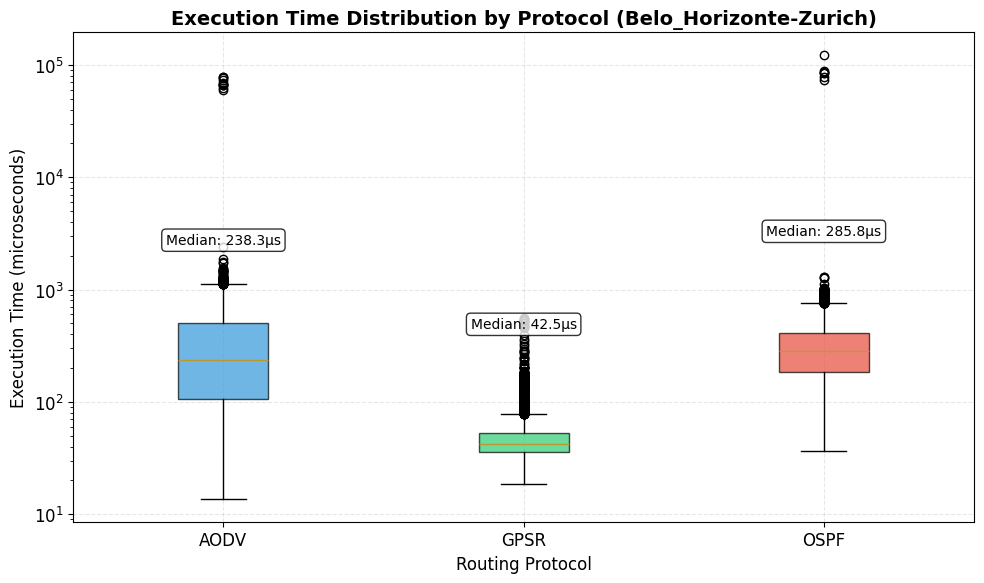

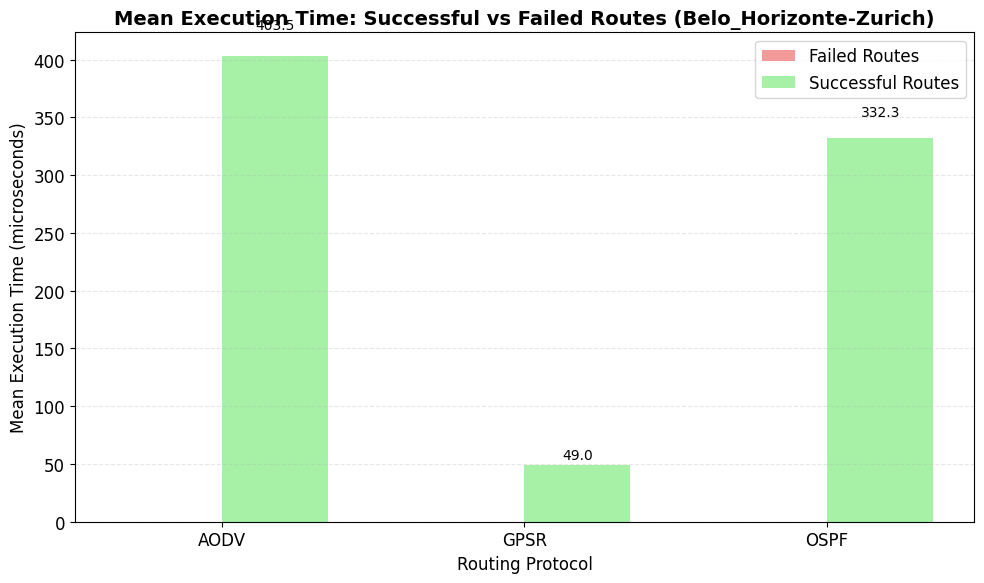

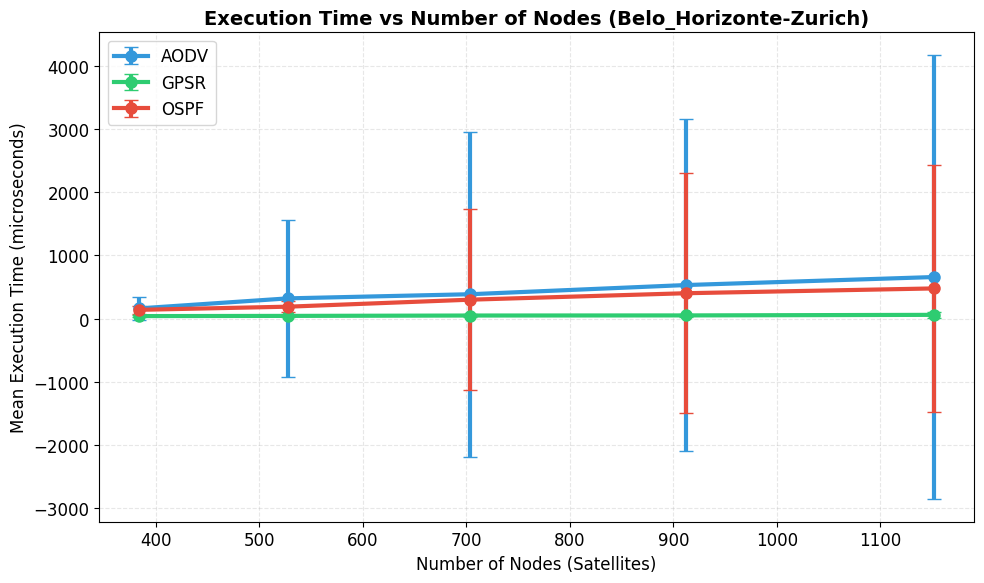

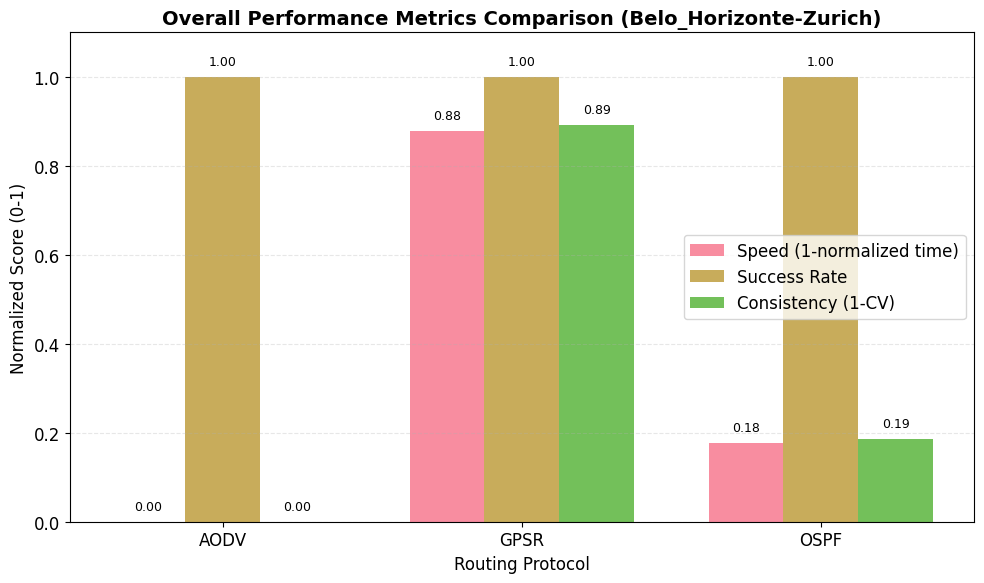

In [126]:
# Create individual performance visualizations
print("📊 INDIVIDUAL ALGORITHM PERFORMANCE VISUALIZATIONS")
print("=" * 60)

protocols = sorted(bh_zurich_clean['protocol'].unique())
colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red

# Plot 1: Execution Time Distribution (Box Plot)
plt.figure(figsize=(10, 6))
exec_time_data = [bh_zurich_clean[bh_zurich_clean['protocol'] == p]['time_taken_us'] for p in protocols]
box_plot = plt.boxplot(exec_time_data, labels=protocols, patch_artist=True)

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Execution Time (microseconds)', fontsize=12)
plt.xlabel('Routing Protocol', fontsize=12)
plt.title('Execution Time Distribution by Protocol (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log')  # Log scale for better visualization

# Add statistics annotations
for i, protocol in enumerate(protocols):
    data = bh_zurich_clean[bh_zurich_clean['protocol'] == protocol]['time_taken_us']
    median_val = data.median()
    plt.text(i+1, median_val*10, f'Median: {median_val:.1f}μs', 
             ha='center', va='bottom', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot 2: Mean Execution Time by Protocol and Success Status
plt.figure(figsize=(10, 6))
success_comparison = performance_stats.pivot(index='protocol', columns='route_success', values='Mean_Time')

x_pos = np.arange(len(protocols))
width = 0.35

# Handle missing data by filling with 0 or using available data
failed_data = success_comparison[False].fillna(0) if False in success_comparison.columns else [0] * len(protocols)
success_data = success_comparison[True].fillna(0) if True in success_comparison.columns else [0] * len(protocols)

bars1 = plt.bar(x_pos - width/2, failed_data, width, 
                label='Failed Routes', alpha=0.8, color='lightcoral')
bars2 = plt.bar(x_pos + width/2, success_data, width, 
                label='Successful Routes', alpha=0.8, color='lightgreen')

plt.ylabel('Mean Execution Time (microseconds)', fontsize=12)
plt.xlabel('Routing Protocol', fontsize=12)
plt.title('Mean Execution Time: Successful vs Failed Routes (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, protocols)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if not np.isnan(height) and height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    if not np.isnan(height) and height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 3: Execution Time vs Number of Nodes
plt.figure(figsize=(10, 6))

for i, protocol in enumerate(protocols):
    protocol_data = bh_zurich_clean[bh_zurich_clean['protocol'] == protocol]
    node_time_stats = protocol_data.groupby('num_nodes')['time_taken_us'].agg(['mean', 'std']).reset_index()
    
    plt.errorbar(node_time_stats['num_nodes'], node_time_stats['mean'], 
                yerr=node_time_stats['std'], marker='o', linewidth=3, 
                markersize=8, label=protocol, color=colors[i], capsize=5)

plt.xlabel('Number of Nodes (Satellites)', fontsize=12)
plt.ylabel('Mean Execution Time (microseconds)', fontsize=12)
plt.title('Execution Time vs Number of Nodes (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Performance Summary (Bar Chart)
plt.figure(figsize=(10, 6))

# Create grouped bar chart for multiple metrics
x_pos = np.arange(len(protocols))
width = 0.25

# Normalize metrics for comparison (0-1 scale)
norm_mean_time = 1 - (overall_performance['Mean_Time_us'] / overall_performance['Mean_Time_us'].max())
norm_success_rate = overall_performance['Success_Rate']
norm_consistency = 1 - (overall_performance['CV_Time'] / overall_performance['CV_Time'].max())

bars1 = plt.bar(x_pos - width, norm_mean_time, width, label='Speed (1-normalized time)', alpha=0.8)
bars2 = plt.bar(x_pos, norm_success_rate, width, label='Success Rate', alpha=0.8)
bars3 = plt.bar(x_pos + width, norm_consistency, width, label='Consistency (1-CV)', alpha=0.8)

plt.ylabel('Normalized Score (0-1)', fontsize=12)
plt.xlabel('Routing Protocol', fontsize=12)
plt.title('Overall Performance Metrics Comparison (Belo_Horizonte-Zurich)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, protocols)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [127]:
# Final Performance Ranking and Conclusions
print("🏆 ALGORITHM PERFORMANCE RANKING")
print("=" * 50)

# Calculate comprehensive performance score
performance_ranking = overall_performance.copy()

# Create performance score (higher is better)
# Normalize metrics: faster time = higher score, higher success rate = higher score, lower CV = higher score
max_time = performance_ranking['Mean_Time_us'].max()
max_cv = performance_ranking['CV_Time'].max()

performance_ranking['Speed_Score'] = (max_time - performance_ranking['Mean_Time_us']) / max_time
performance_ranking['Success_Score'] = performance_ranking['Success_Rate']
performance_ranking['Consistency_Score'] = (max_cv - performance_ranking['CV_Time']) / max_cv

# Weighted overall score (you can adjust weights based on importance)
performance_ranking['Overall_Score'] = (
    0.4 * performance_ranking['Speed_Score'] +      # 40% weight on speed
    0.4 * performance_ranking['Success_Score'] +    # 40% weight on success rate
    0.2 * performance_ranking['Consistency_Score']  # 20% weight on consistency
)

performance_ranking = performance_ranking.sort_values('Overall_Score', ascending=False)

print("📊 Final Performance Ranking (Higher Score = Better Performance):")
print("-" * 70)
display(performance_ranking[['protocol', 'Mean_Time_us', 'Success_Rate', 'CV_Time', 
                           'Speed_Score', 'Success_Score', 'Consistency_Score', 'Overall_Score']].round(4))

# Determine the best performing algorithm
best_algorithm = performance_ranking.iloc[0]['protocol']
best_score = performance_ranking.iloc[0]['Overall_Score']
best_time = performance_ranking.iloc[0]['Mean_Time_us']
best_success = performance_ranking.iloc[0]['Success_Rate']

print(f"\n🥇 BEST PERFORMING ALGORITHM: {best_algorithm}")
print("=" * 50)
print(f"   📈 Overall Performance Score: {best_score:.4f}")
print(f"   ⚡ Average Execution Time: {best_time:.2f} microseconds")
print(f"   ✅ Success Rate: {best_success:.1%}")
print(f"   🎯 Coefficient of Variation: {performance_ranking.iloc[0]['CV_Time']:.4f}")

print(f"\n📊 PERFORMANCE SUMMARY:")
print("-" * 30)
for i, row in performance_ranking.iterrows():
    protocol = row['protocol']
    score = row['Overall_Score']
    time_us = row['Mean_Time_us']
    success = row['Success_Rate']
    
    if i == 0:
        print(f"🥇 {protocol}: Best overall performance (Score: {score:.3f})")
        print(f"   └─ Fastest execution: {time_us:.1f}μs, Success: {success:.1%}")
    elif i == 1:
        print(f"🥈 {protocol}: Good performance (Score: {score:.3f})")
        print(f"   └─ Execution time: {time_us:.1f}μs, Success: {success:.1%}")
    else:
        print(f"🥉 {protocol}: Moderate performance (Score: {score:.3f})")
        print(f"   └─ Execution time: {time_us:.1f}μs, Success: {success:.1%}")

print(f"\n💡 KEY INSIGHTS:")
print("-" * 20)
print(f"• Fastest algorithm: {performance_ranking.loc[performance_ranking['Mean_Time_us'].idxmin(), 'protocol']}")
print(f"• Most successful: {performance_ranking.loc[performance_ranking['Success_Rate'].idxmax(), 'protocol']}")
print(f"• Most consistent: {performance_ranking.loc[performance_ranking['CV_Time'].idxmin(), 'protocol']}")
print(f"• Best balanced performance: {best_algorithm}")


🏆 ALGORITHM PERFORMANCE RANKING
📊 Final Performance Ranking (Higher Score = Better Performance):
----------------------------------------------------------------------


,protocol,Mean_Time_us,Success_Rate,CV_Time,Speed_Score,Success_Score,Consistency_Score,Overall_Score
1,GPSR,49.052,1.0,0.611,0.8784,1.0,0.8916,0.9297
2,OSPF,332.308,1.0,4.593,0.1764,1.0,0.1853,0.5076
0,AODV,403.494,1.0,5.638,0.0000,1.0,0.0000,0.4000



🥇 BEST PERFORMING ALGORITHM: GPSR
   📈 Overall Performance Score: 0.9297
   ⚡ Average Execution Time: 49.05 microseconds
   ✅ Success Rate: 100.0%
   🎯 Coefficient of Variation: 0.6110

📊 PERFORMANCE SUMMARY:
------------------------------
🥈 GPSR: Good performance (Score: 0.930)
   └─ Execution time: 49.1μs, Success: 100.0%
🥉 OSPF: Moderate performance (Score: 0.508)
   └─ Execution time: 332.3μs, Success: 100.0%
🥇 AODV: Best overall performance (Score: 0.400)
   └─ Fastest execution: 403.5μs, Success: 100.0%

💡 KEY INSIGHTS:
--------------------
• Fastest algorithm: GPSR
• Most successful: GPSR
• Most consistent: GPSR
• Best balanced performance: GPSR
